# Monte-Carlo Simulations

In [1]:
import matplotlib.pyplot as plt
from proj_3_module import *

### A Simple Weighted Die Simulation

The game is set up such that a roll on 1 or 2 gives 1$ whereas a roll on the other numbers awards your friend 1$.
To cheat the system, you bring a weighted die that has sides 1 and 2 each 3x more likely to roll than the other sides. A Markov Chain Monte Carlo (MCMC) simulation is run to predict your expected (average) earnings of the game.

In [7]:
def which_side(coin, prob_of_one):
    if coin > prob_of_one:
        return 1
    else:
        return 0
 
def weighted_die(num_steps):
    state = 0 #we win, ie 1 or 2
    prob = {0 : 3/5, 1 : 2/5}
    track = np.zeros(num_steps)
    earnings = 0
    for i in range(num_steps):
        coin = np.random.randint(0, 1001, size = 1)/1000
        propose = which_side(coin, 0.5)
        P_current = prob[state]
        P_proposed = prob[propose]
        P_accept = min(1, P_proposed/P_current)
        rand = np.random.randint(0, 1001, size = 1)/1000
        if rand < P_accept:
            state = propose
        if state == 0:
            earnings += 1
        else:
            earnings -= 1
        track[i] = earnings
    return earnings/num_steps

In [9]:
#The exact solution is easily calculated to be 0.2
print("MCMC solution: ", weighted_die(10000))

MCMC solution:  0.2032


### Classical 2D Ising Model

The spin state of a 2D ising model is explored using an MCMC simulation.

In [ ]:
def outbond(val,vallim):
    if val < 0:
        return -1
    elif val == vallim:
        return 0
    else:
        return val
    
def get_energy_diff(state, site):
    diff = 0
    size = state.shape[0]
    diff += state[outbond(site[0]-1, size), site[1]]
    diff += state[outbond(site[0]+1, size), site[1]]
    diff += state[site[0], outbond(site[1]-1, size)]
    diff += state[site[0], outbond(site[1]+1, size)]
    return state[site[0], site[1]]*diff*2

def get_energy(state):
    energy = 0
    for i in range(state.shape[0]-1):
        for j in range(state.shape[1]-1):
            energy += ((-1)*state[i,j]*state[i,j+1] + (-1)*state[i,j]*state[i+1,j])
    for k in range(state.shape[0]-1):
        energy += (-1)*state[k,-1]*state[k+1,-1] + (-1)*state[k,-1]*state[k,0]
    for l in range(state.shape[1]-1):
        energy += (-1)*state[-1,l]*state[-1,l+1] + (-1)*state[-1, l]*state[0,l]
    energy += (-1)*state[-1, -1]*state[-1,0] + (-1)*state[-1,-1]*state[0,-1]
    return energy



def two_dim_ising(temp, num_steps, size, origin=np.ones((1,1))):
    if origin.shape==(1,1):
        state = np.ones((size,size))
    else:
        state = np.copy(origin)
    track = np.zeros(num_steps)
    energy = get_energy(state)*np.ones(num_steps)
    
    for i in range(num_steps):
        proposed_site = [np.random.randint(0, size, size = 1), np.random.randint(0, size, size = 1)]
        energy_diff = get_energy_diff(state, proposed_site)
        val = np.exp(-energy_diff/temp)
        p_accept = min(1, val)
        rand = np.random.rand(1)
        if rand < p_accept:
            state[proposed_site[0],proposed_site[1]] *= -1
            energy[i:] += energy_diff
        track[i] = state.mean()
    
    return state, track, energy/size**2


In [2]:
temp = 5
size1 = 16
size2 = 32

def get_mean_energy(state):
    energy = 0
    for i in range(state.shape[0]-1):
        for j in range(state.shape[1]-1):
            energy += ((-1)*state[i,j]*state[i,j+1] + (-1)*state[i,j]*state[i+1,j])
    for k in range(state.shape[0]-1):
        energy += (-1)*state[k,-1]*state[k+1,-1] + (-1)*state[k,-1]*state[k,0]
    for l in range(state.shape[1]-1):
        energy += (-1)*state[-1,l]*state[-1,l+1] + (-1)*state[-1, l]*state[0,l]
    energy += (-1)*state[-1, -1]*state[-1,0] + (-1)*state[-1,-1]*state[0,-1]
    return energy / (state.shape[0])**2



state1, track1, e1 = two_dim_ising(temp, num_steps=1000*size1**2, size=size1)
state2, track2, e2 = two_dim_ising(temp, num_steps=1000*size2**2, size=size2)



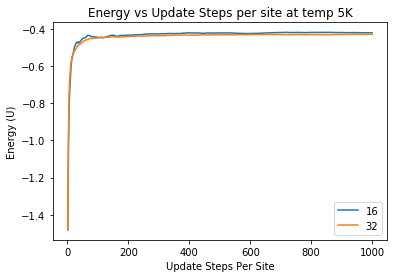

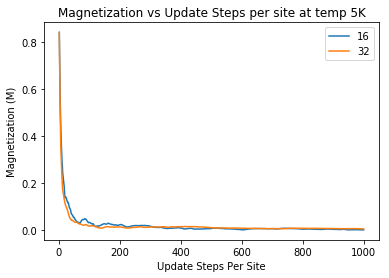

In [3]:
t = np.arange(1,1001,1)
U1 = np.zeros(t.size)
M1 = np.zeros(t.size)
for i in range(1000):
    U1[i]=e1[:(i+1)*size1**2].mean()
    M1[i]=track1[:(i+1)*size1**2].mean()

U2 = np.zeros(t.size)
M2 = np.zeros(t.size)
for i in range(1000):
    U2[i]=e2[:(i+1)*size2**2].mean()
    M2[i]=track2[:(i+1)*size2**2].mean()




plt.plot(t, U1)
plt.plot(t, U2)
plt.legend(("16", "32"))
plt.title("Energy vs Update Steps per site at temp 5K")
plt.xlabel("Update Steps Per Site")
plt.ylabel("Energy (U)")
plt.show()


plt.plot(t, M1)
plt.plot(t, M2)
plt.legend(("16", "32"))
plt.xlabel("Update Steps Per Site")
plt.ylabel("Magnetization (M)")
plt.title("Magnetization vs Update Steps per site at temp 5K")
plt.show()



For the energy, the system converges around 100 update steps per site for the 32 sized lattice and around 150 update steps per site for the 16 sized lattice. As the lattice size gets larger, the lower update steps per site it takes for the system to converge.

For the magnetization, the system converges around 150 update steps per site for the 32 sized lattice and around 200 update steps per site for the 16 sized lattice. As the lattice size gets larger, the lower update steps per site it takes for the system to converge.


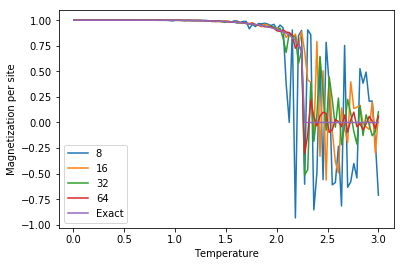

In [4]:
critTemp = 2 / np.log(1 + (2**(1/2)))
def onsagerM(temp):
    if temp >= critTemp:
        return 0
    return (1 - (np.sinh(2/temp)**(-4)))**(1/8)


def createState(mean, size):
    state = np.ones((size**2))
    negNum = (size**2) - int(((1 + mean)/2)*(size**2))
    randSites = np.random.choice(size**2, negNum, replace=False)
    state[randSites] *= -1
    state = state.reshape((size, size))
    return state

temps = np.linspace(0.01, 3, num=100)
exact = np.zeros((temps.size))
for i in range(temps.size):
    exact[i] = onsagerM(temps[i])


sizes = np.array([8, 16, 32, 64])
magall = {}
for k in sizes:
    mag = np.zeros((temps.size))
    starting = np.ones((k,k))
    for i in range(temps.size):
        mean = onsagerM(temps[i])
        originState = createState(mean, k)
        state, track, e = two_dim_ising(temps[i], 100 * (k**2), k, origin=originState)
        mag[i] = track[-int(0.2*track.size):].mean()
    plt.plot(temps, mag)
    magall[k]=mag
    
plt.plot(temps, exact)
plt.legend(("8", "16", "32", "64", "Exact"))
plt.xlabel("Temperature")
plt.ylabel("Magnetization per site")
plt.show()

As the lattice size increases, the closer it follows the exact results of Onsager's equation. The smaller the lattice size, the larger the fluctuations from the exact solution.

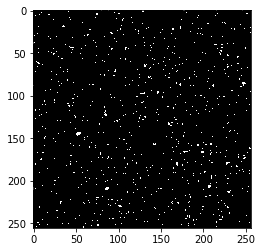

In [3]:
size = 256
T = np.array([1.8, 2.3, 4.0])
state, track, e = two_dim_ising(T[0], 1000*(32**2), size)
plt.imshow(state, cmap='binary', vmin = -1, vmax = 1)
plt.show()

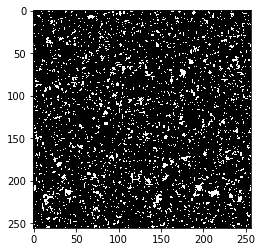

In [4]:
state, track, e = two_dim_ising(T[1], 1000*(32**2), size)
plt.imshow(state, cmap='binary', vmin = -1, vmax = 1)
plt.show()

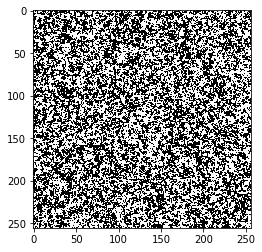

In [5]:
state, track, e = two_dim_ising(T[2], 1000*(32**2), size)
plt.imshow(state, cmap='binary', vmin = -1, vmax = 1)
plt.show()

At temperatures below the critical temperature, the grid appears to be closer to all black (they are almost all in the same spin configuration). Near the critical temperature, there is a significant amount of particles in a different spin configuration than the majority. The spin up configuration begins to lose a large amount of its majority. Above the critical temperature, it appears to be closer to 50/50 for each particle's spin configuration.